### Corrective RAG
- Corrective RAG (often called Corrective Retrieval-Augmented Generation) is a new pattern in RAG systems where the model not only retrieves documents but detects, corrects, and rewrites bad retrieval results before generating the final answer.
- Think of it as RAG + Error Correction.

#### Simple Definition
- Corrective RAG is a workflow where the system evaluates retrieved documents, identifies irrelevant or incomplete information, corrects the retrieval by rewriting or reframing the query, retrieves again, and only then generates the final answer.
- It fixes retrieval failures before the answer is produced.

#### Why Corrective RAG?
Normal RAG fails in these cases:
- retrieval returns irrelevant documents
- retrieved chunks don’t contain the necessary information
- the query is ambiguous
- user provides insufficient details
In standard RAG → The model still tries to answer and hallucinates.
Corrective RAG → The system detects the problem and fixes the retrieval loop, improving precision drastically.

#### How Corrective RAG Works (High-Level)
Corrective RAG usually involves 3 intelligent components:
1. Retriever
    Fetches initial documents.
2. Evaluator / Grader
    Checks:
    - Are documents relevant?
    - Are they complete enough?
    - Do they answer the question?
    If “No”: send to corrective step.
3. Corrector / Rewriter
    Improves:
    - search query
    - missing details
    - user question rewrite
    - constraints  
    Then re-runs retrieval.
4. Generator
    Produces the final answer only when evaluator accepts the retrieved documents.

#### 🔄 Corrective RAG Loop (Flow)

User Question  
     ↓  
Retrieval  
     ↓  
Evaluator (Are docs relevant?)  
     ↓ Yes               ↓ No  
Final Answer       Rewriter → Retrieve Again  

This continues until grader says "documents OK".

#### Example Scenario
User asks:  
    “Explain how vector databases work.”  
Retriever returns:
- vector embeddings intro
- similarity search
- irrelevant chunk about SQL indexes  

Evaluator says: ❌ documents are not relevant enough.  
Corrector rewrites the query to:  
    “How do vector databases work? Include embedding storage, approximate nearest neighbor search, and indexing.”  
Retriever fetches better documents.  
Evaluator says: ✔️ documents relevant.  
Generator produces final answer.  

#### Corrective RAG in LangGraph
Your own workflow matches Corrective RAG:
- retrieve → evaluate → rewrite → retrieve → evaluate → generate  
The grade_documents function in your graph is exactly the evaluator.  
If it returns "rewrite", the system fixes retrieval before generating the final answer.  
This is classic Corrective RAG.


In [2]:
# Imports
from typing import Annotated, List, Sequence
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

llm = ChatOpenAI(name="gpt-5-nano")
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a subset of artificial intelligence that involves the development of algorithms and statistical models that enable computers to improve their performance on a specific task or set of tasks through experience and data. Essentially, machine learning allows computers to learn and make predictions or decisions without being explicitly programmed to do so. It is used in a wide range of applications, such as natural language processing, image recognition, medical diagnosis, and autonomous driving, among others.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 12, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CbzprJWDlzMg0JQNytg1WgS5

In [3]:
# RAG imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
urls = ["https://docs.langchain.com/oss/python/langgraph/graph-api",
        "https://docs.langchain.com/oss/python/langgraph/functional-api"]

docs = WebBaseLoader(urls).load()
docs

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/graph-api', 'title': 'Graph API overview - Docs by LangChain', 'language': 'en'}, page_content='Graph API overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KGitHubTry LangSmithTry LangSmithSearch...NavigationGraph APIGraph API overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewLangGraph v1.0Release notesMigration guideGet startedInstallQuickstartLocal serverThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureStudioTestDeployAgent Chat UIObservabilityLangGraph APIsGraph APIGraph APIUse the graph APIFunctional APIRuntimeOn this pageGraphsStateGraphCompiling your graphStateSchemaMultiple schemasReducersDefault ReducerOverwriteWorking with Messages in Graph StateWhy use messages?Using Messages in your GraphSerializationM

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents=docs)

vectorstore = FAISS.from_documents(documents=doc_splits, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

In [6]:
# Retrieval grader
from langchain_core.prompts import ChatPromptTemplate

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents"""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system_prompt = """You are a grader assessing relevance of retrieved documents to a user question. \n
    If the documents contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate(
    [
        SystemMessage(content=system_prompt),
        HumanMessage(content="Retrieved documents: {documents} \n\n User question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What are different ways to define the StateGraph?"
docs = retriever.invoke(question)
doc_text = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_text}))

c:\MyDrive\SelfStudyCode\AI\Krish\AgenticAI\venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


binary_score='yes'


In [7]:
# Generate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate.from_template(template="""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context}
Answer:
""")

rag_chain = prompt | llm | StrOutputParser()
response = rag_chain.invoke({"context": docs, "question": question})
print(response)

The StateGraph class is the main graph class to use, and it is parameterized by a user-defined State object. To define a StateGraph, you need to first define the state, add nodes and edges, and then compile the graph. Compiling the graph is necessary before using it for execution.


In [8]:
# Rewrite

# Prompt
system_prompt = """
You are a question re-writer that converts an input question to a better version that is optimized by re-phrasing the question with the correct and complete sentence using web search. \n
 Look at the input and try to reason about the underlying semantic intent/meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "Here is the question: {question} \n Re-write this question to make it complete and semantically correct.")
    ],
)
rag_rewrite_chain = re_write_prompt | llm | StrOutputParser()
response = rag_rewrite_chain.invoke({"question": question})
print(response)

What are the various methods of defining a StateGraph in computer science?


In [10]:
# Web search tool - Tavily
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)
web_search_tool.invoke({"query": "Who is Sachin tendulkar?"})

[{'title': 'Sachin Tendulkar | Biography, Stats, Records, Age, Centuries ...',
  'url': 'https://www.britannica.com/biography/Sachin-Tendulkar',
  'content': 'Sachin Tendulkar (born April 24, 1973, Bombay [Mumbai], India) is a former Indian professional cricket player, considered by many to be one of the greatest batters of all time. He is the leading run scorer in both Test cricket and one-day internationals (ODIs) and the first cricketer to score 100 centuries (100 runs in a single innings) in international cricket. Often compared to Australian great Don Bradman, Tendulkar became known for his confident stroke play off both the front and back foot. [...] Sachin Tendulkar was India’s top run scorer in the 2011 World Cup-winning campaign. He considers winning the World Cup the crowning achievement of his career.\n\n### What were some of Sachin Tendulkar’s achievements in the Indian Premier League (IPL)?\n\nIn the IPL Sachin Tendulkar played for the Mumbai Indians, captaining the team f

In [11]:
class GraphState(TypedDict):
    """
    Represents the state of the graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: wheather to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [ ]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current state of the graph
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer.
    Args:
        state (dict): The current state of the graph
    Returns:
        state (dict): New key added to state, documents, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines wheather the retrieved documents are relevant to the question.
    Args:
        state (dict): The current state of the graph
    Returns:
        state (dict): Updates documents key with only filtered relevant documents.
    """
    print("---CHECK DOCUMENTS RELEVANCE TO THE QUESTION")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "documents": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def transform_query(state):
    """
    Transform the query to a better question.
    Args:
        state (dict): The current state of the graph
    Returns:
        state (dict): Updates question key with re-phrased question.
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    
    better_question = rag_rewrite_chain.invoke({"question": question})

    return {"question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
        state (dict): The current state of the graph
    Returns:
        state (dict): Updates documents key with appended web results.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join(d["content"] for d in docs)
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

# Edges

def decide_to_geneate(state):
    """
    Decides wheather to generate the answer or re-generate the question.
    Args:
        state (dict): The current state of the graph
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSES GRADED DOCUMENTS---")
    web_search = state["web_search"]
    if web_search == "Yes":
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE ANSWER---")
        return "generate"

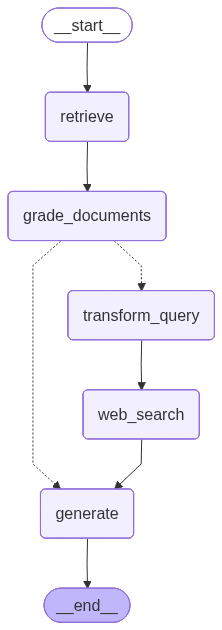

In [14]:
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents",
            decide_to_geneate,
            {
                "transform_query": "transform_query",
                "generate": "generate"
            }
        )
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

# View graph
graph_image = app.get_graph(xray=True).draw_mermaid_png()
display(Image(graph_image))

In [16]:
app.invoke({"question": "ways to prepare a cake?"})

---RETRIEVE---
---CHECK DOCUMENTS RELEVANCE TO THE QUESTION
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSES GRADED DOCUMENTS---
---DECISION: TRANSFORM QUERY---
---TRANSFORM QUERY
---WEB SEARCH
---GENERATE---


{'question': 'What are the various methods for preparing a cake?',
 'generation': 'Various methods for preparing a cake include the creaming method, whisked method, all-in-one method, foam cakes, and oil-based cakes. Each method has specific steps and ingredients that result in different textures and flavors of cakes, ranging from light and airy to moist and rich. The choice of method depends on the desired outcome and the type of cake being made.',
 'web_search': 'Yes',
 'documents': [Document(id='3f48aefe-eaa2-4f78-b45b-319b806ec5b9', metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/graph-api', 'title': 'Graph API overview - Docs by LangChain', 'language': 'en'}, page_content='By default, the graph will have the same input and output schemas. If you want to change this, you can also specify explicit input and output schemas directly. This is useful when you have a lot of keys, and some are explicitly for input and others for output. See the guide for more informat